In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from IPython.display import Image
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.models as models

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report

C:\Users\papul.DESKTOP-U29R0P8.000\AppData\Local\Temp\ipykernel_14988\3522734162.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dataset_path = '../../data/processed'
image_size = (128, 128)

transform = T.Compose([
    T.Resize(image_size),
    T.Grayscale(num_output_channels=3),  # Преобразование в трехканальное изображение
    T.ToTensor(),
    T.Normalize(mean=[0.4], std=[0.7])  # Использованы одноканальные значения
])

# Создание датасета изображений
dataset = ImageFolder(dataset_path, transform=transform)

# Разделение датасета на обучающую и валидационную выборки
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создание загрузчиков данных для обучения и валидации
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
train_size

1107

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 1384
    Root location: stuff/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.4], std=[0.7])
           )

In [4]:
val_size

277

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cpu'

In [64]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([32, 3, 128, 128])


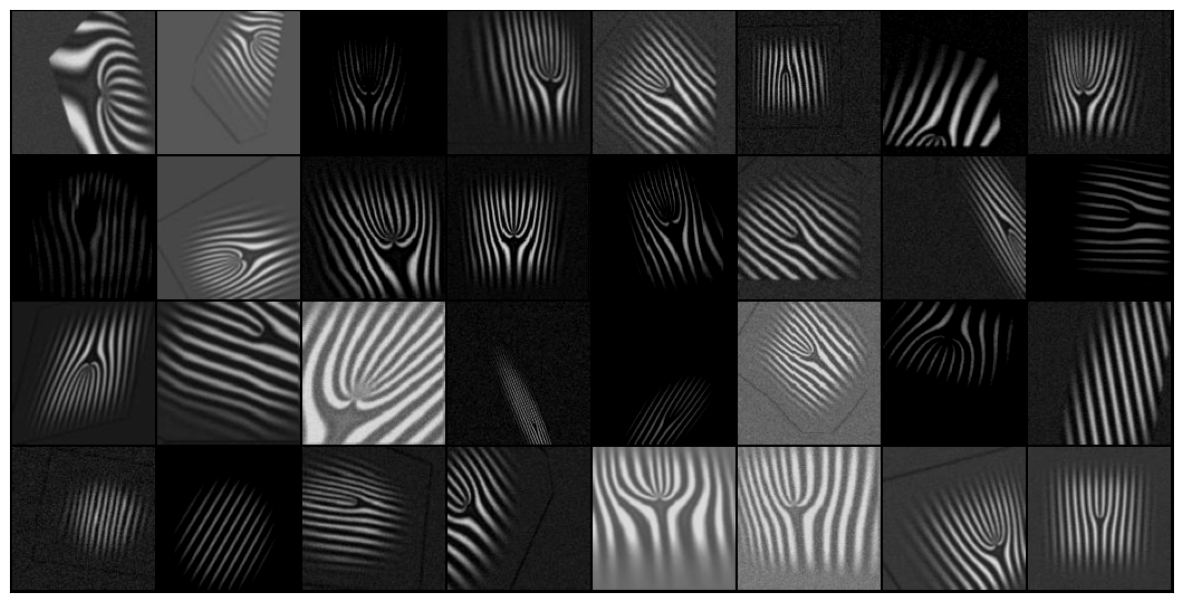

In [65]:
show_batch(train_loader)

In [66]:
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [93]:
model.classifier[1] = nn.Linear(1280, 5) #добавление последнего слоя с нужным числом классов

In [94]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss() 

In [95]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [96]:
metrics = { "loss" : Loss(criterion), 
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=5)}

In [97]:
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [98]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [99]:
# коллбэк для вывода результатов обучения после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}".format(trainer.state.epoch, accuracy, loss))

In [100]:
# коллбэк для вывода результатов валидации после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy'] * 100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}".format(trainer.state.epoch, accuracy, loss))

In [101]:
# остановка обучения, если accuracy не превышает максимальное значение на протяжении 7 эпох
breaker = EarlyStopping(patience=7, score_function=lambda engine: engine.state.metrics['accuracy'], trainer=trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker)

In [102]:
# сохранение модели с наибольшей accuracy
to_save = {'model': model}
saver = Checkpoint(
    to_save, '../../models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [103]:
# для отображения времени обучения и прогресс бара
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True, bar_format='')
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

In [104]:
# добавляет матрицу ошибок после обучения
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))  
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="d")
    ax.set_xlabel('Предсказанные заряды')
    ax.set_ylabel('Истинные заряды') 

  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 89.88 Сред. ошибка: 0.26542
Результат валидации - Эпоха: 1  Сред. точность: 79.06 Сред. ошибка: 0.57664


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 96.66 Сред. ошибка: 0.10491
Результат валидации - Эпоха: 2  Сред. точность: 87.36 Сред. ошибка: 0.43550


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 94.22 Сред. ошибка: 0.15347
Результат валидации - Эпоха: 3  Сред. точность: 83.39 Сред. ошибка: 0.49759


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 92.14 Сред. ошибка: 0.29842
Результат валидации - Эпоха: 4  Сред. точность: 79.78 Сред. ошибка: 0.74678


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 96.66 Сред. ошибка: 0.09361
Результат валидации - Эпоха: 5  Сред. точность: 89.89 Сред. ошибка: 0.33414


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.39 Сред. ошибка: 0.10830
Результат валидации - Эпоха: 6  Сред. точность: 85.92 Сред. ошибка: 0.50986


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 96.39 Сред. ошибка: 0.09244
Результат валидации - Эпоха: 7  Сред. точность: 89.53 Сред. ошибка: 0.31795


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 95.30 Сред. ошибка: 0.16119
Результат валидации - Эпоха: 8  Сред. точность: 85.20 Сред. ошибка: 0.56932


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 97.38 Сред. ошибка: 0.09176
Результат валидации - Эпоха: 9  Сред. точность: 87.00 Сред. ошибка: 0.39241


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.55 Сред. ошибка: 0.02195
Результат валидации - Эпоха: 10  Сред. точность: 88.09 Сред. ошибка: 0.31947


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.55 Сред. ошибка: 0.01373
Результат валидации - Эпоха: 11  Сред. точность: 92.06 Сред. ошибка: 0.31685


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 98.92 Сред. ошибка: 0.03728
Результат валидации - Эпоха: 12  Сред. точность: 88.45 Сред. ошибка: 0.39495


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 98.83 Сред. ошибка: 0.03336
Результат валидации - Эпоха: 13  Сред. точность: 86.64 Сред. ошибка: 0.37287


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.64 Сред. ошибка: 0.01006
Результат валидации - Эпоха: 14  Сред. точность: 90.61 Сред. ошибка: 0.40193


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.19 Сред. ошибка: 0.03648
Результат валидации - Эпоха: 15  Сред. точность: 87.36 Сред. ошибка: 0.39729


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.01 Сред. ошибка: 0.03748
Результат валидации - Эпоха: 16  Сред. точность: 84.48 Сред. ошибка: 0.40295


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.28 Сред. ошибка: 0.02531
Результат валидации - Эпоха: 17  Сред. точность: 87.73 Сред. ошибка: 0.49494


  3%|2         | 1/35 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.19 Сред. ошибка: 0.03063


2024-05-19 15:20:59,849 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 18  Сред. точность: 86.28 Сред. ошибка: 0.69084


2024-05-19 15:21:10,046 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 630
	epoch: 18
	epoch_length: 35
	max_epochs: 50
	output: 0.09205760806798935
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

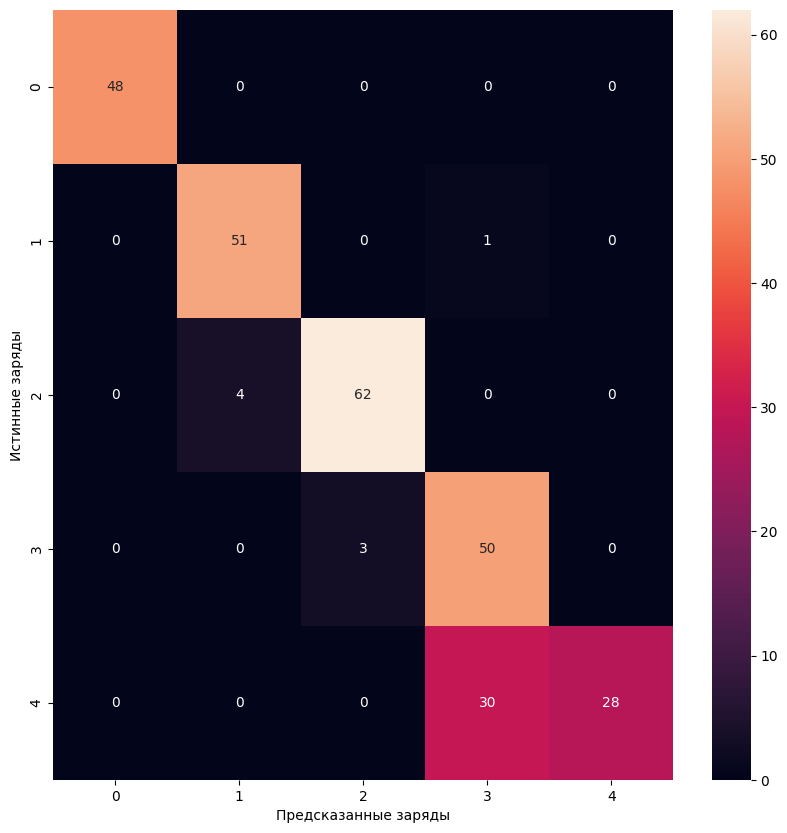

In [105]:
trainer.run(train_loader, max_epochs=50)

In [106]:
# загрузка модели
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('../../models')))
print("Модель загружена")

Модель загружена


## Проверяем модель и строим графики

In [107]:
def get_preds(model, loader, device):
    model.eval()
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)

    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
          
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
        y_true = y_true.cpu().numpy()  
        _, y_pred = torch.max(all_outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    
    return y_true, y_pred, y_pred_prob

In [108]:
y_true, y_pred, _ = get_preds(model, test_loader, device)

In [109]:
print(classification_report(y_true, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           2       0.94      0.96      0.95        52
           4       0.91      0.97      0.94        66
           6       0.81      0.87      0.84        53
           8       0.96      0.81      0.88        58

    accuracy                           0.92       277
   macro avg       0.92      0.92      0.92       277
weighted avg       0.92      0.92      0.92       277



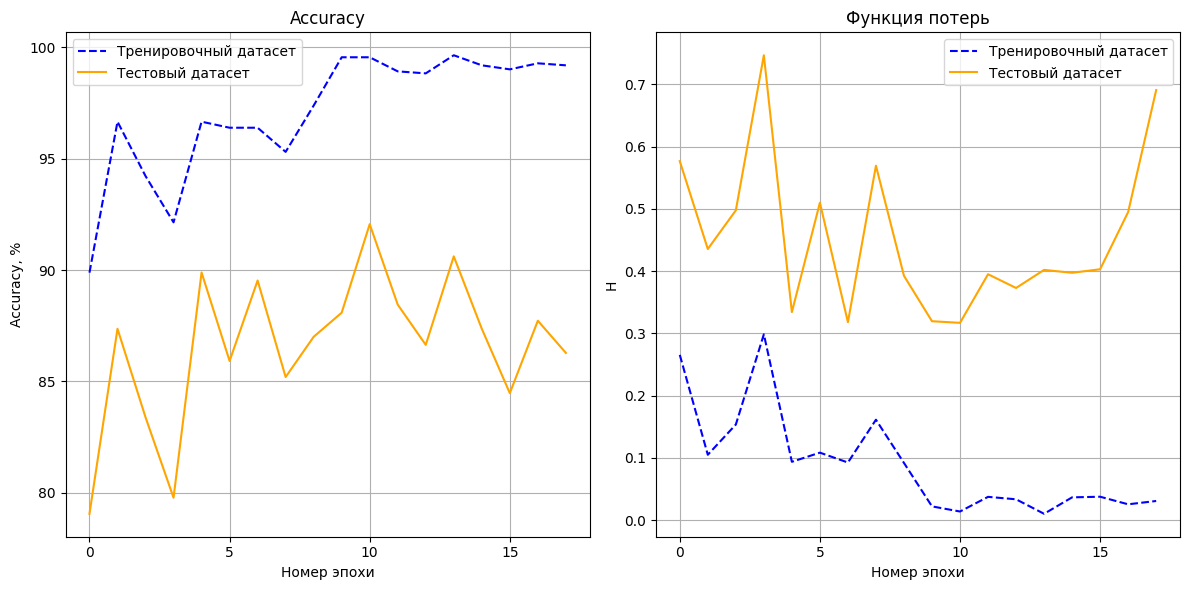

In [110]:
train_acc = training_history['accuracy']
train_loss = training_history['loss']
test_acc = test_history['accuracy']
test_loss = test_history['loss']
plt.figure(figsize=(12, 6))

# График для accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Тренировочный датасет', color='blue', linestyle='--')
plt.plot(test_acc, label='Тестовый датасет', color='orange')
plt.title('Accuracy')
plt.xlabel('Номер эпохи')
plt.ylabel('Accuracy, %')
plt.xticks(np.arange(0, len(train_acc), step=5))  
plt.grid(True)
plt.legend()

# График для loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Тренировочный датасет', color='blue', linestyle='--')
plt.plot(test_loss, label='Тестовый датасет', color='orange')
plt.title('Функция потерь')
plt.xlabel('Номер эпохи')
plt.ylabel('Н')
plt.xticks(np.arange(0, len(train_acc), step=5))  
plt.grid(True)
plt.legend()

# Отображаем графики
plt.tight_layout()
plt.show()

array([[0.002, 0.027, 0.876, 0.091, 0.003]], dtype=float32)

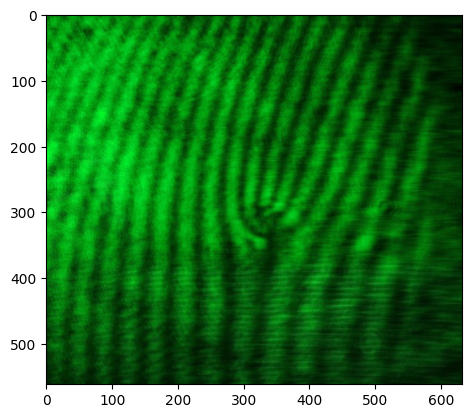

In [116]:
# проверка на реальных фотоы
from PIL import Image
transform = T.Compose([
    T.Resize(image_size),
    T.Grayscale(num_output_channels=3),  # Преобразование в трехканальное изображение
    T.ToTensor(),
    T.Normalize(mean=[0.4], std=[0.7])  # Попробуйте использовать одноканальные значения
])

img = Image.open('2.jpg')
plt.imshow(img)
tensor = transform(img)
tensor = tensor.to(device)
tensor = tensor.unsqueeze_(0)
model.eval()
output = model(tensor)
probs = F.softmax(output.to('cpu'), dim=1).detach().numpy()
np.round(probs, 3)